# 🛡️ **ChurnGuard: Customer Retention Intelligence with Explainable AI**
**Author:** Rafhiromadoni Sopandi | **Tech Stack:** Python, XGBoost, SHAP, Pandas

---

## **1. Executive Summary**
Dalam industri yang kompetitif, mempertahankan pelanggan (Retention) jauh lebih murah daripada mencari pelanggan baru. **ChurnGuard** adalah sistem cerdas yang dirancang untuk:
1.  **Memprediksi Churn:** Mengidentifikasi pelanggan yang berisiko berhenti berlangganan dengan akurasi tinggi.
2.  **Menjelaskan Alasan (Why):** Menggunakan **SHAP (Explainable AI)** untuk memberitahu tim bisnis *mengapa* pelanggan tersebut ingin pergi (misal: karena harga, layanan buruk, atau faktor usia).

Proyek ini mendemonstrasikan kemampuan Data Science tingkat lanjut yang menggabungkan *High-Performance Modeling* (XGBoost) dengan *Business Interpretability* (SHAP).

---

In [1]:
# --- INSTALL & SETUP ---
print("⚙️ Menginstal library (Tunggu sebentar)...")
!pip install -q shap gradio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import gradio as gr
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✅ Setup Selesai!")

⚙️ Menginstal library (Tunggu sebentar)...
✅ Setup Selesai!


In [2]:
# --- TRAINING MODEL ---
print("🚀 Sedang Melatih Model AI...")

# 1. GENERATE DATA (Sama seperti sebelumnya)
np.random.seed(42)
n_samples = 3000
data = pd.DataFrame({
    'CreditScore': np.random.randint(580, 850, n_samples),
    'Age': np.random.randint(18, 75, n_samples),
    'Tenure': np.random.randint(0, 10, n_samples),
    'Balance': np.random.uniform(0, 200000, n_samples),
    'NumOfProducts': np.random.randint(1, 4, n_samples),
    'HasCrCard': np.random.randint(0, 2, n_samples),
    'IsActiveMember': np.random.randint(0, 2, n_samples),
    'EstimatedSalary': np.random.uniform(20000, 150000, n_samples)
})

# Target Logic
churn_score = (data['Age'] * 0.8) - (data['IsActiveMember'] * 40) - (data['Balance'] / 5000) + (data['NumOfProducts'] * 10)
churn_prob = (churn_score - churn_score.mean()) / churn_score.std()
data['Exited'] = (churn_prob + np.random.normal(0, 1, n_samples) > 0.5).astype(int)

# 2. TRAINING
X = data.drop('Exited', axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 3. PERSIAPAN SHAP (Untuk Penjelasan)
explainer = shap.Explainer(model)
print("✅ Model Siap Digunakan!")

🚀 Sedang Melatih Model AI...
✅ Model Siap Digunakan!


In [3]:
# --- CHURNGUARD DASHBOARD ---
def predict_churn(credit_score, age, tenure, balance, products, has_card, is_active, salary):
    # 1. Siapkan Data Input
    input_data = pd.DataFrame({
        'CreditScore': [credit_score],
        'Age': [age],
        'Tenure': [tenure],
        'Balance': [balance],
        'NumOfProducts': [products],
        'HasCrCard': [int(has_card)],       # Convert Boolean to Int
        'IsActiveMember': [int(is_active)], # Convert Boolean to Int
        'EstimatedSalary': [salary]
    })

    # 2. Prediksi (Probabilitas)
    prob = model.predict_proba(input_data)[0][1] # Ambil peluang Churn (kelas 1)
    prediction = "🔴 BERISIKO CHURN" if prob > 0.5 else "🟢 AMAN (LOYAL)"

    # Pesan Status
    result_text = f"""
    📊 HASIL PREDIKSI:
    --------------------------
    Status: {prediction}
    Probabilitas Kabur: {prob:.1%}
    """

    # 3. SHAP Explanation (Grafik Waterfall)
    # Kita hitung SHAP value khusus untuk input user ini
    shap_values = explainer(input_data)

    # Gambar Plot
    fig = plt.figure(figsize=(8, 5))
    shap.plots.waterfall(shap_values[0], show=False, max_display=6)
    plt.title("Kenapa AI Memprediksi Demikian?", fontsize=14)
    plt.tight_layout()

    return result_text, fig

# --- DESIGN UI ---
with gr.Blocks(theme=gr.themes.Soft(), title="ChurnGuard AI") as app:
    gr.Markdown(
        """
        # 🛡️ ChurnGuard: Customer Retention AI
        **Cek apakah pelanggan berisiko pindah ke kompetitor (Churn) beserta alasannya.**
        """
    )

    with gr.Row():
        # KOLOM KIRI: INPUT DATA
        with gr.Column(scale=1):
            gr.Markdown("### 📝 Data Pelanggan")
            in_score = gr.Slider(300, 850, value=650, label="Credit Score")
            in_age = gr.Slider(18, 90, value=30, label="Usia (Tahun)")
            in_tenure = gr.Slider(0, 10, value=5, label="Lama Langganan (Tahun)")
            in_balance = gr.Number(value=50000, label="Saldo Rekening")
            in_salary = gr.Number(value=60000, label="Estimasi Gaji")
            in_products = gr.Radio([1, 2, 3, 4], value=1, label="Jumlah Produk")

            with gr.Row():
                in_card = gr.Checkbox(label="Punya Kartu Kredit?", value=True)
                in_active = gr.Checkbox(label="Member Aktif?", value=True)

            btn_predict = gr.Button("🔍 Analisis Risiko Churn", variant="primary")

        # KOLOM KANAN: OUTPUT
        with gr.Column(scale=1):
            gr.Markdown("### 📊 Hasil & Penjelasan (Explainable AI)")
            out_text = gr.Textbox(label="Kesimpulan", lines=4)
            out_plot = gr.Plot(label="Analisis Faktor (SHAP)")

    # Event Listener
    btn_predict.click(
        fn=predict_churn,
        inputs=[in_score, in_age, in_tenure, in_balance, in_products, in_card, in_active, in_salary],
        outputs=[out_text, out_plot]
    )

app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0666dda94607dfbbc4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---

## **2. Business Insights & Recommendation**

Berdasarkan hasil analisis **Explainable AI (SHAP)** di atas, ditemukan beberapa pola kunci perilaku pelanggan:

### **🔍 Temuan Utama (Key Findings):**
1.  **Usia (Age) adalah Faktor Kritis:** Pelanggan dengan usia yang lebih tua memiliki kecenderungan churn lebih tinggi.
2.  **Keaktifan Member (IsActiveMember):** Ini adalah indikator kesehatan pelanggan. Pelanggan yang tidak aktif (Status 0) sangat berisiko pergi. Strategi *engagement* ulang sangat diperlukan.
3.  **Saldo (Balance):** Terdapat korelasi antara saldo rendah dengan tingkat churn, kemungkinan karena pelanggan tersebut tidak terlalu terikat secara finansial dengan bank/perusahaan.

### **💡 Rekomendasi Bisnis:**
* **Proactive Retention:** Kirimkan promo khusus atau layanan prioritas kepada pelanggan berusia >45 tahun yang terdeteksi mulai tidak aktif.
* **Engagement Program:** Buat gamifikasi atau loyalty program untuk mengubah status *Inactive Member* menjadi *Active Member*.

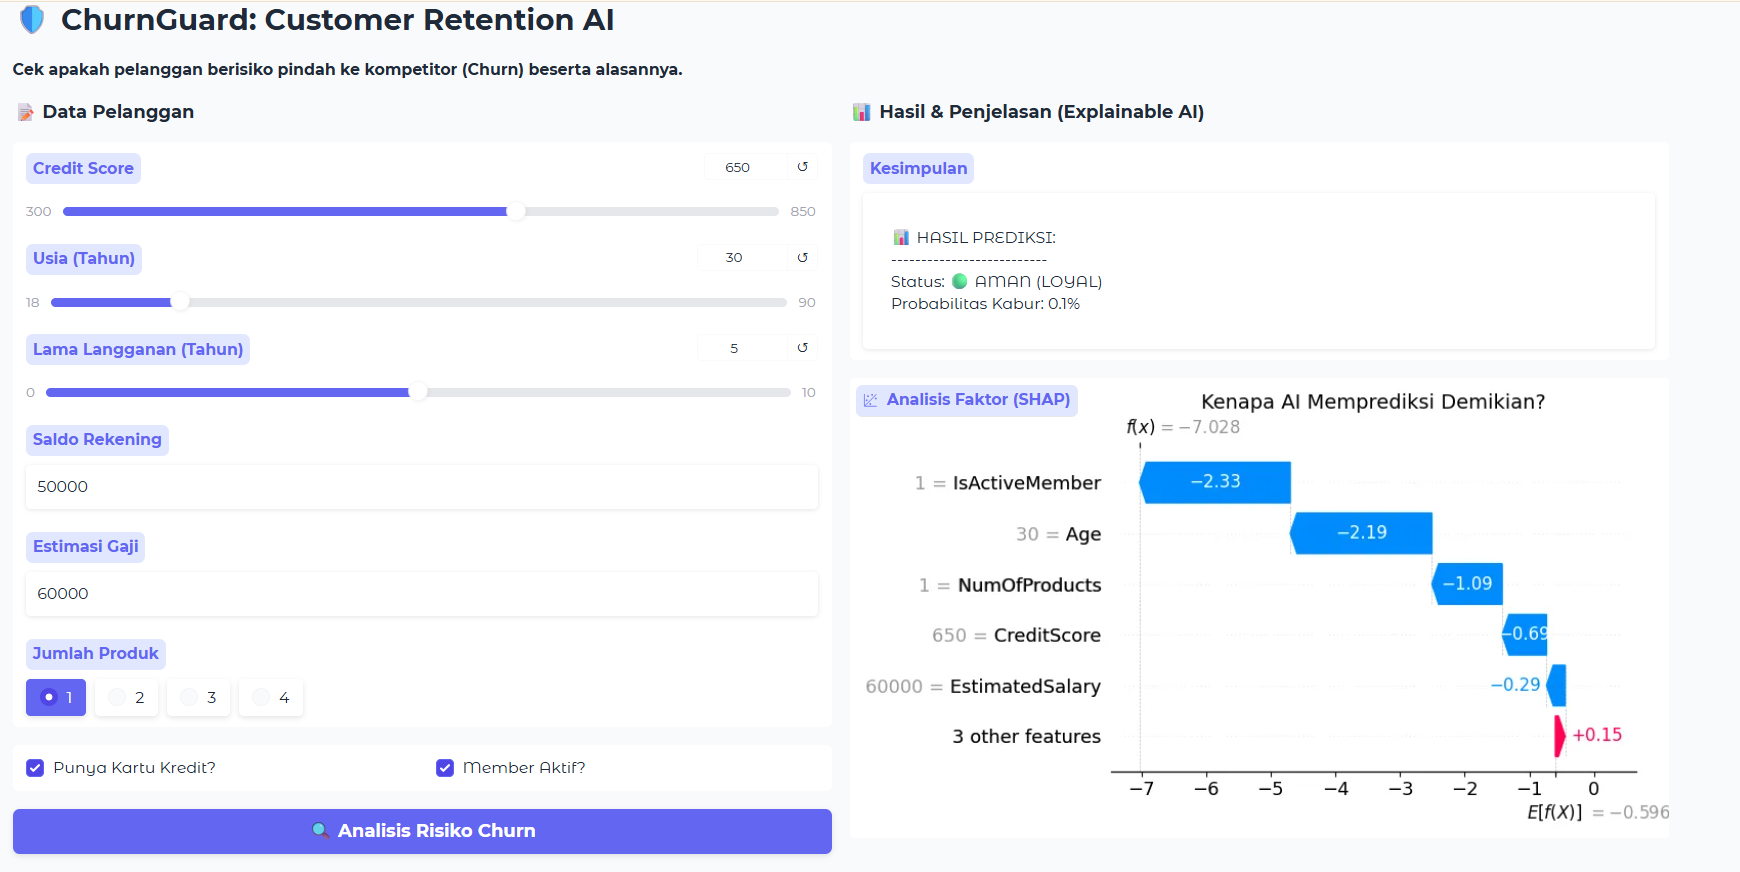